# Tutorial for polydispersity in bulk Monte Carlo simulations in the structural-color package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to polydispersity with bulk Monte Carlo simulations

One of the advantages of the bulk montecarlo model is that we can sample phase functions and scattering lengths for spheres of different sizes in a bulk film. This means we can predict the reflectance of bulk films made of mixtures of spheres with different sizes, allowing us to simulate polydispersity using the bulk Monte Carlo model. 

Below is an example that calculates a reflectance spectrum from a bulk film made of polydisperse spheres, where the internal structure of each sphere is the same. 

## Loading and using the package and module

You'll need the following imports

In [2]:
import numpy as np
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
from structcol import phase_func_sphere as pfs
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# The following will cause specific warnings to be ignored
import warnings
from pint.errors import UnitStrippedWarning
warnings.filterwarnings('ignore',
                        category=UserWarning,
                        message='.*n_particle and n_matrix not specified')
warnings.filterwarnings('ignore',
                        category=UnitStrippedWarning)

So that you can reproduce the results in this notebook, we use a seeded random number generator. The code will then produce the same trajectories each time. For your own code, you should change the cell below to read `rng=None`, or set up your own random number generator.

In [4]:
seed = 1
rng = np.random.RandomState([seed])
# Uncomment the following for your own code
#rng = None

## Start by running Monte Carlo code for a single sphere
This is essentially the same as running MC for a sphere as described in montecarlo_tutorial.ipynb, only we return a few extra parameters from calc_refl_trans() and use them to calculate the phase function, scattering coefficient, and absorption coefficient for the bulk Monte Carlo simulation.

#### Set parameters
We have to set a few extra parameters for the bulk simulation

In [5]:
# Properties of the source
wavelengths = sc.Quantity(np.arange(400., 801.,10),'nm') # wavelengths at which to calculate reflectance

# Geometric properties of the sample
num_diams = 3                                     # number of diams from which to sample,
                                                  # higher number takes longer but gives a more precise calculation
sphere_boundary_diam_mean = sc.Quantity(10,'um')  # mean diameter of the microspheres
pdi = 0.2                                         # poldispersity index
particle_radius = sc.Quantity(160,'nm')           # radii of the two species of particles
volume_fraction_bulk = sc.Quantity(0.63,'')       # volume fraction of the spheres in the bulk film
volume_fraction_particles = sc.Quantity(0.55, '') # volume fraction of the particles in the sphere boundary
bulk_thickness = sc.Quantity('50 um')             # thickness of the bulk film
boundary = 'sphere'                              # geometry of sample
boundary_bulk = 'film'                           # geometry of the bulk sample

# Refractive indices
n_particle = ri.n('vacuum', wavelengths)    # refractive index of particle
n_matrix = ri.n('polystyrene', wavelengths) + 2e-5*1j # refractive index of matrix
n_matrix_bulk = ri.n('vacuum', wavelengths) # refractive index of the bulk matrix
n_medium = ri.n('vacuum', wavelengths)      # refractive index of medium outside the bulk sample.

# Monte Carlo parameters
ntrajectories = 500          # number of trajectories to run with a spherical boundary
nevents = 300                # number of scattering events for each trajectory in a spherical boundary
ntrajectories_bulk = 1000    # number of trajectories to run in the bulk film
nevents_bulk = 300           # number of events to run in the bulk film

# Plot settings
sns.set_style('white')        # sets white plotting background

#### Sample sphere boundary sizes

Calculate a list of sphere boundary diameters based on the polydispersity of the spheres. This list will be used to calculate phase functions and scattering/absorption coefficients for single spheres, to use in the bulk model. In this example, we assume each sphere has the same particle packings inside.

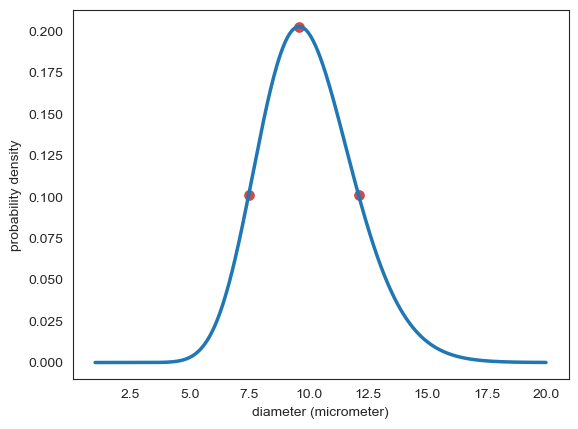

In [6]:
# calculate diameter list to sample from

sphere_boundary_diameters = pfs.calc_diam_list(num_diams, sphere_boundary_diam_mean, 
                                               pdi, equal_spacing = False)

### Run Monte Carlo for each of the sphere boundary sizes

Run Monte Carlo simulations for a sphere boundary, for all the sizes of spheres calculated above. This will give two scattering parameters for sphere size and each wavelength. 

In [7]:
reflectance_sphere = np.zeros(wavelengths.size)
p_bulk = np.zeros((sphere_boundary_diameters.size, wavelengths.size, 200))
mu_scat_bulk = sc.Quantity(np.zeros((sphere_boundary_diameters.size, wavelengths.size)),'1/um')
mu_abs_bulk = sc.Quantity(np.zeros((sphere_boundary_diameters.size, wavelengths.size)),'1/um')

for j in range(sphere_boundary_diameters.size):
    # print radius to keep track of where we are in calculation
    print('diameter: ' + str(sphere_boundary_diameters[j]))
    for i in range(wavelengths.size):

        # caculate the effective index of the sample
        n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction_particles)

        # Calculate the phase function and scattering and absorption coefficients from the single scattering model
        # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
        p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle[i], n_sample,
                                          volume_fraction_particles, wavelengths[i])

        # Initialize the trajectories
        r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_matrix_bulk[i], n_sample,
                                    boundary, 
                                    sample_diameter = sphere_boundary_diameters[j], rng=rng)
        r0 = sc.Quantity(r0, 'um')
        k0 = sc.Quantity(k0, '')
        W0 = sc.Quantity(W0, '')

        # Create trajectories object
        trajectories = mc.Trajectory(r0, k0, W0)

        # Generate a matrix of all the randomly sampled angles first
        sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories,
                                                                    p, rng=rng)

        # Create step size distribution
        step = mc.sample_step(nevents, ntrajectories, mu_scat, rng=rng)

        # Run photons
        trajectories.absorb(mu_abs, step)
        trajectories.scatter(sintheta, costheta, sinphi, cosphi)
        trajectories.move(step)

        # Calculate reflection and transmition
        (refl_indices,
         trans_indices,
         _, _, _,
         refl_per_traj, trans_per_traj,
         _,_,_,_,
         reflectance_sphere[i],
         _,_, norm_refl, norm_trans) = det.calc_refl_trans(trajectories, sphere_boundary_diameters[j],
                                  n_matrix_bulk[i], n_sample, boundary,
                                  run_fresnel_traj = False,
                                  return_extra = True)


        ### Calculate phase function and lscat ###
        # use output of calc_refl_trans to calculate phase function, mu_scat, and mu_abs for the bulk
        p_bulk[j,i,:], mu_scat_bulk[j,i], mu_abs_bulk[j,i] = pfs.calc_scat_bulk(refl_per_traj,
                                                                                trans_per_traj,
                                                                                refl_indices,
                                                                                trans_indices,
                                                                                norm_refl,
                                                                                norm_trans,
                                                                                volume_fraction_bulk,
                                                                                sphere_boundary_diameters[j],
                                                                                n_matrix_bulk[i],
                                                                                wavelengths[i],
                                                                                plot=False,
                                                                                phi_dependent=False)


diameter: 7.470784641068447 micrometer
diameter: 9.595993322203672 micrometer
diameter: 12.101836393989982 micrometer


### Sample distribution of sphere boundary radii

Given the pdi of the sphere boundary radius and the mean radii of the sphere boundaries, sample the particle radii for each event and trajectory.

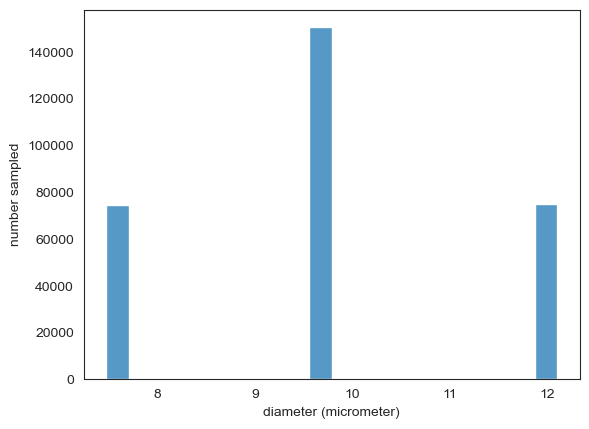

In [8]:
# sample
sphere_diams_sampled = pfs.sample_diams(pdi, sphere_boundary_diameters,
                                       sphere_boundary_diam_mean,
                                       ntrajectories_bulk,
                                       nevents_bulk, rng=rng)

# plot
sns.histplot(np.ndarray.flatten(sphere_diams_sampled), kde = False)
plt.ylabel('number sampled')
plt.xlabel('diameter (' + str(sphere_boundary_diameters.units) + ')');

### Calculate reflectance of bulk polydisperse film
The only difference from a normal bulk reflectance calculation (see bulk_montecarlo_tutorial.ipynb) is that we use the function pfs.sample_angles_step_poly() instead of sample_angles() and sample_step()

Note that for mixtures of different sphere types, absorption only works in the bulk matrix, not in the spheres themselves. This is because sampling the different absorption lengths for different sphere types has not yet been implemented. 

In [9]:
reflectance_bulk_poly = np.zeros(wavelengths.size)
for i in range(wavelengths.size):

    # print the wavelength keep track of where we are in calculation
    print('wavelength: ' + str(wavelengths[i]))

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents_bulk, ntrajectories_bulk, n_medium[i], n_matrix_bulk[i],
                              boundary_bulk, rng=rng)
    r0 = sc.Quantity(r0, 'um')
    W0 = sc.Quantity(W0, '')
    k0 = sc.Quantity(k0, '')

    # Sample angles and calculate step size based on sampled radii
    sintheta, costheta, sinphi, cosphi, step, _, _ = pfs.sample_angles_step_poly(nevents_bulk, ntrajectories_bulk,
                                                            p_bulk[:,i,:],
                                                            sphere_diams_sampled,
                                                            mu_scat_bulk[:,i],
                                                            param_list = sphere_boundary_diameters,
                                                            rng=rng)


    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    trajectories.absorb(mu_abs_bulk[0,i], step) # Note: polydisperse absorption does not currently work in the bulk
                                                # so we arbitrarily use index 0, assuming that all scattering events
                                                # have the same amount of absorption
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)
    trajectories.move(step)

    # calculate reflectance
    reflectance_bulk_poly[i], transmittance = det.calc_refl_trans(trajectories, bulk_thickness,
                                                               n_medium[i], n_matrix_bulk[i], boundary_bulk)

wavelength: 400.0 nanometer
wavelength: 410.0 nanometer
wavelength: 420.0 nanometer
wavelength: 430.0 nanometer
wavelength: 440.0 nanometer
wavelength: 450.0 nanometer
wavelength: 460.0 nanometer
wavelength: 470.0 nanometer
wavelength: 480.0 nanometer
wavelength: 490.0 nanometer
wavelength: 500.0 nanometer
wavelength: 510.0 nanometer
wavelength: 520.0 nanometer
wavelength: 530.0 nanometer
wavelength: 540.0 nanometer
wavelength: 550.0 nanometer
wavelength: 560.0 nanometer
wavelength: 570.0 nanometer
wavelength: 580.0 nanometer
wavelength: 590.0 nanometer
wavelength: 600.0 nanometer
wavelength: 610.0 nanometer
wavelength: 620.0 nanometer
wavelength: 630.0 nanometer
wavelength: 640.0 nanometer
wavelength: 650.0 nanometer
wavelength: 660.0 nanometer
wavelength: 670.0 nanometer
wavelength: 680.0 nanometer
wavelength: 690.0 nanometer
wavelength: 700.0 nanometer
wavelength: 710.0 nanometer
wavelength: 720.0 nanometer
wavelength: 730.0 nanometer
wavelength: 740.0 nanometer
wavelength: 750.0 na

### Plot results

Text(0.5, 1.0, 'Bulk Reflectance')

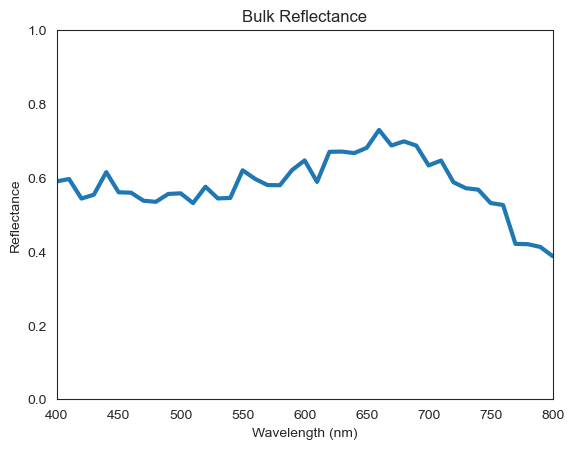

In [10]:
plt.figure()
plt.plot(wavelengths, reflectance_bulk_poly, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Bulk Reflectance')